In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time

from torch_geometric.datasets import TUDataset
import torchmetrics

import torchhd
from torchhd import embeddings
from torchhd.models import Centroid

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda device


In [124]:
DIMENSIONS = 10000

dataset = "PROTEINS"
print(f"Testing {dataset}")

graphs = TUDataset("../data", dataset)
train_size = int(0.7 * len(graphs))
test_size = len(graphs) - train_size

train_ld, test_ld = torch.utils.data.random_split(graphs, [train_size, test_size])


def degree_centrality(G):
    """
    Compute the degree centrality for nodes.
    """
    _, columns = G.edge_index
    degree = torch.bincount(columns, minlength=G.num_nodes)
    return degree / G.num_nodes


def to_undirected(edge_index):
    """
    Returns the undirected edge_index
    [[0, 1], [1, 0]] will result in [[0], [1]]
    """
    edge_index = edge_index.sort(dim=0)[0]
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index


def min_max_graph_size(graph_dataset):
    if len(graph_dataset) == 0:
        return None, None

    max_num_nodes = float("-inf")
    min_num_nodes = float("inf")

    for G in graph_dataset:
        num_nodes = G.num_nodes
        max_num_nodes = max(max_num_nodes, num_nodes)
        min_num_nodes = min(min_num_nodes, num_nodes)

    return min_num_nodes, max_num_nodes


class Encoder(nn.Module):
    def __init__(self, out_features, size):
        super(Encoder, self).__init__()
        self.out_features = out_features
        self.node_ids = embeddings.Random(size, out_features)

    def forward(self, x):
        pr = degree_centrality(x)
        _, pr_argsort = pr.sort()

        node_id_hvs = torch.zeros((x.num_nodes, self.out_features), device=device)
        node_id_hvs[pr_argsort] = self.node_ids.weight[: x.num_nodes]

        row, col = to_undirected(x.edge_index)

        hvs = torchhd.bind(node_id_hvs[row], node_id_hvs[col])
        return torchhd.multiset(hvs)


min_graph_size, max_graph_size = min_max_graph_size(graphs)

encoder = Encoder(DIMENSIONS, max_graph_size)
encoder = encoder.to(device)

model = Centroid(DIMENSIONS, graphs.num_classes)
model = model.to(device)

start = time.time()

with torch.no_grad():
    for samples in tqdm(train_ld, desc="Training"):
        samples.edge_index = samples.edge_index.to(device)
        samples.y = samples.y.to(device)

        test_samples_hv = encoder(samples).unsqueeze(0)
        model.add(test_samples_hv, samples.y)

f1score = torchmetrics.F1Score("multiclass", num_classes=graphs.num_classes)

with torch.no_grad():
    model.normalize()

    for index, samples in enumerate(tqdm(test_ld, desc="Testing_")):
        samples.edge_index = samples.edge_index.to(device)

        test_samples_hv = encoder(samples).unsqueeze(0)
        test_outputs = model(test_samples_hv, dot=True)

        f1score.update(test_outputs.cpu(), samples.y)

end = time.time()

print(f"Test: f1-score of {f1score.compute().item() * 100:.3f}%")
print(f"Time: {(end - start):.3f}s")

Testing PROTEINS


Testing_: 100%|██████████| 334/334 [00:00<00:00, 1091.97it/s]

Test: f1-score of 72.156%
Time: 0.804s


In [121]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# # Load the embeddings
# datafile_path = "data/fine_food_reviews_with_embeddings_1k.csv"
# df = pd.read_csv(datafile_path)

# # Convert to a list of lists of floats
# matrix = np.array(df.embedding.apply(literal_eval).to_list())

# matrix = embeddings.Circular(500, DIMENSIONS).weight

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=50, random_state=42, init="random", learning_rate=200, metric="cosine")
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(500, 2)

Text(0.5, 1.0, 'Level embeddings visualized using t-SNE')

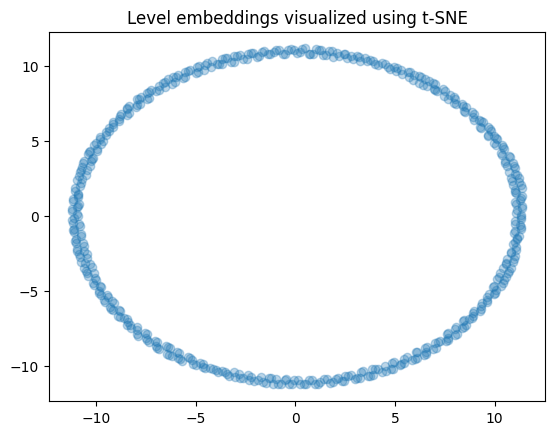

In [122]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]
# color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
# plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.scatter(x, y, alpha=0.3)
for score in [0, 1, 2, 3, 4]:
    # avg_x = np.array(x)[df.Score-1==score].mean()
    # avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    # plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Level embeddings visualized using t-SNE")